<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regression" data-toc-modified-id="Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regression</a></span></li><li><span><a href="#Part-1:-Loading-and-Inspecting-Data" data-toc-modified-id="Part-1:-Loading-and-Inspecting-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 1: Loading and Inspecting Data</a></span></li><li><span><a href="#Part-2:-Simple-Regression" data-toc-modified-id="Part-2:-Simple-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 2: Simple Regression</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#2.1:-Linear-Regression" data-toc-modified-id="2.1:-Linear-Regression-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>2.1: Linear Regression</a></span></li></ul></li><li><span><a href="#2.2:-Random-Forest-Regression" data-toc-modified-id="2.2:-Random-Forest-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>2.2: Random Forest Regression</a></span></li><li><span><a href="#2.3-Gradient-Boosted-Regression" data-toc-modified-id="2.3-Gradient-Boosted-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2.3 Gradient Boosted Regression</a></span></li></ul></li><li><span><a href="#Part-3:-Cross-Validation" data-toc-modified-id="Part-3:-Cross-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 3: Cross Validation</a></span></li><li><span><a href="#Part-4:-Evaluating-the-Models" data-toc-modified-id="Part-4:-Evaluating-the-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Part 4: Evaluating the Models</a></span></li></ul></div>

# Regression

In this notebook, I'll demonstrate workflows for performing linear regression. For this purpose, I'll be using the 'Concrete' dataset from the UCI repository

In [1]:
# Load libraries

# General DS Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

# Pre-processing and Scoring
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, scale

# Lime for interpreting things
import lime
import lime.lime_tabular 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Part 1: Loading and Inspecting Data

Here's the load for the "Concrete" dataset and a quick look at it

In [2]:
concrete = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls")
print(concrete.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
Cement (component 1)(kg in a m^3 mixture)                1030 non-null float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    1030 non-null float64
Fly Ash (component 3)(kg in a m^3 mixture)               1030 non-null float64
Water  (component 4)(kg in a m^3 mixture)                1030 non-null float64
Superplasticizer (component 5)(kg in a m^3 mixture)      1030 non-null float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     1030 non-null float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        1030 non-null float64
Age (day)                                                1030 non-null int64
Concrete compressive strength(MPa, megapascals)          1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None


Clearly, a bit of clean-up is useful here. I'll just change the names of each column so they're less onerous. 

In [3]:
# Shorten column names directly
concrete.columns = ['Cement', 'Blast_Slag', 'Fly_Ash', 
                    'Water', 'Superplasticizer', 'Coarse_Aggregate',
                    'Fine_Aggregate', 'Age', 'Compressive_Strength']
print(concrete.head())

   Cement  Blast_Slag  Fly_Ash  Water  Superplasticizer  Coarse_Aggregate  \
0   540.0         0.0      0.0  162.0               2.5            1040.0   
1   540.0         0.0      0.0  162.0               2.5            1055.0   
2   332.5       142.5      0.0  228.0               0.0             932.0   
3   332.5       142.5      0.0  228.0               0.0             932.0   
4   198.6       132.4      0.0  192.0               0.0             978.4   

   Fine_Aggregate  Age  Compressive_Strength  
0           676.0   28             79.986111  
1           676.0   28             61.887366  
2           594.0  270             40.269535  
3           594.0  365             41.052780  
4           825.5  360             44.296075  


So I'll be trying to predict compressive strength given the other components, all of which are numerical types. 

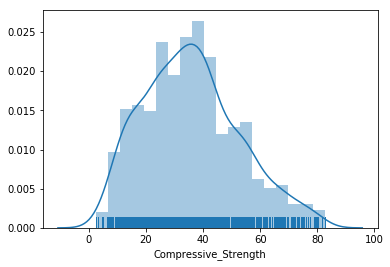

In [4]:
# Plot a histogram
plt.figure()
sns.distplot(concrete.Compressive_Strength, rug = True)
plt.show()

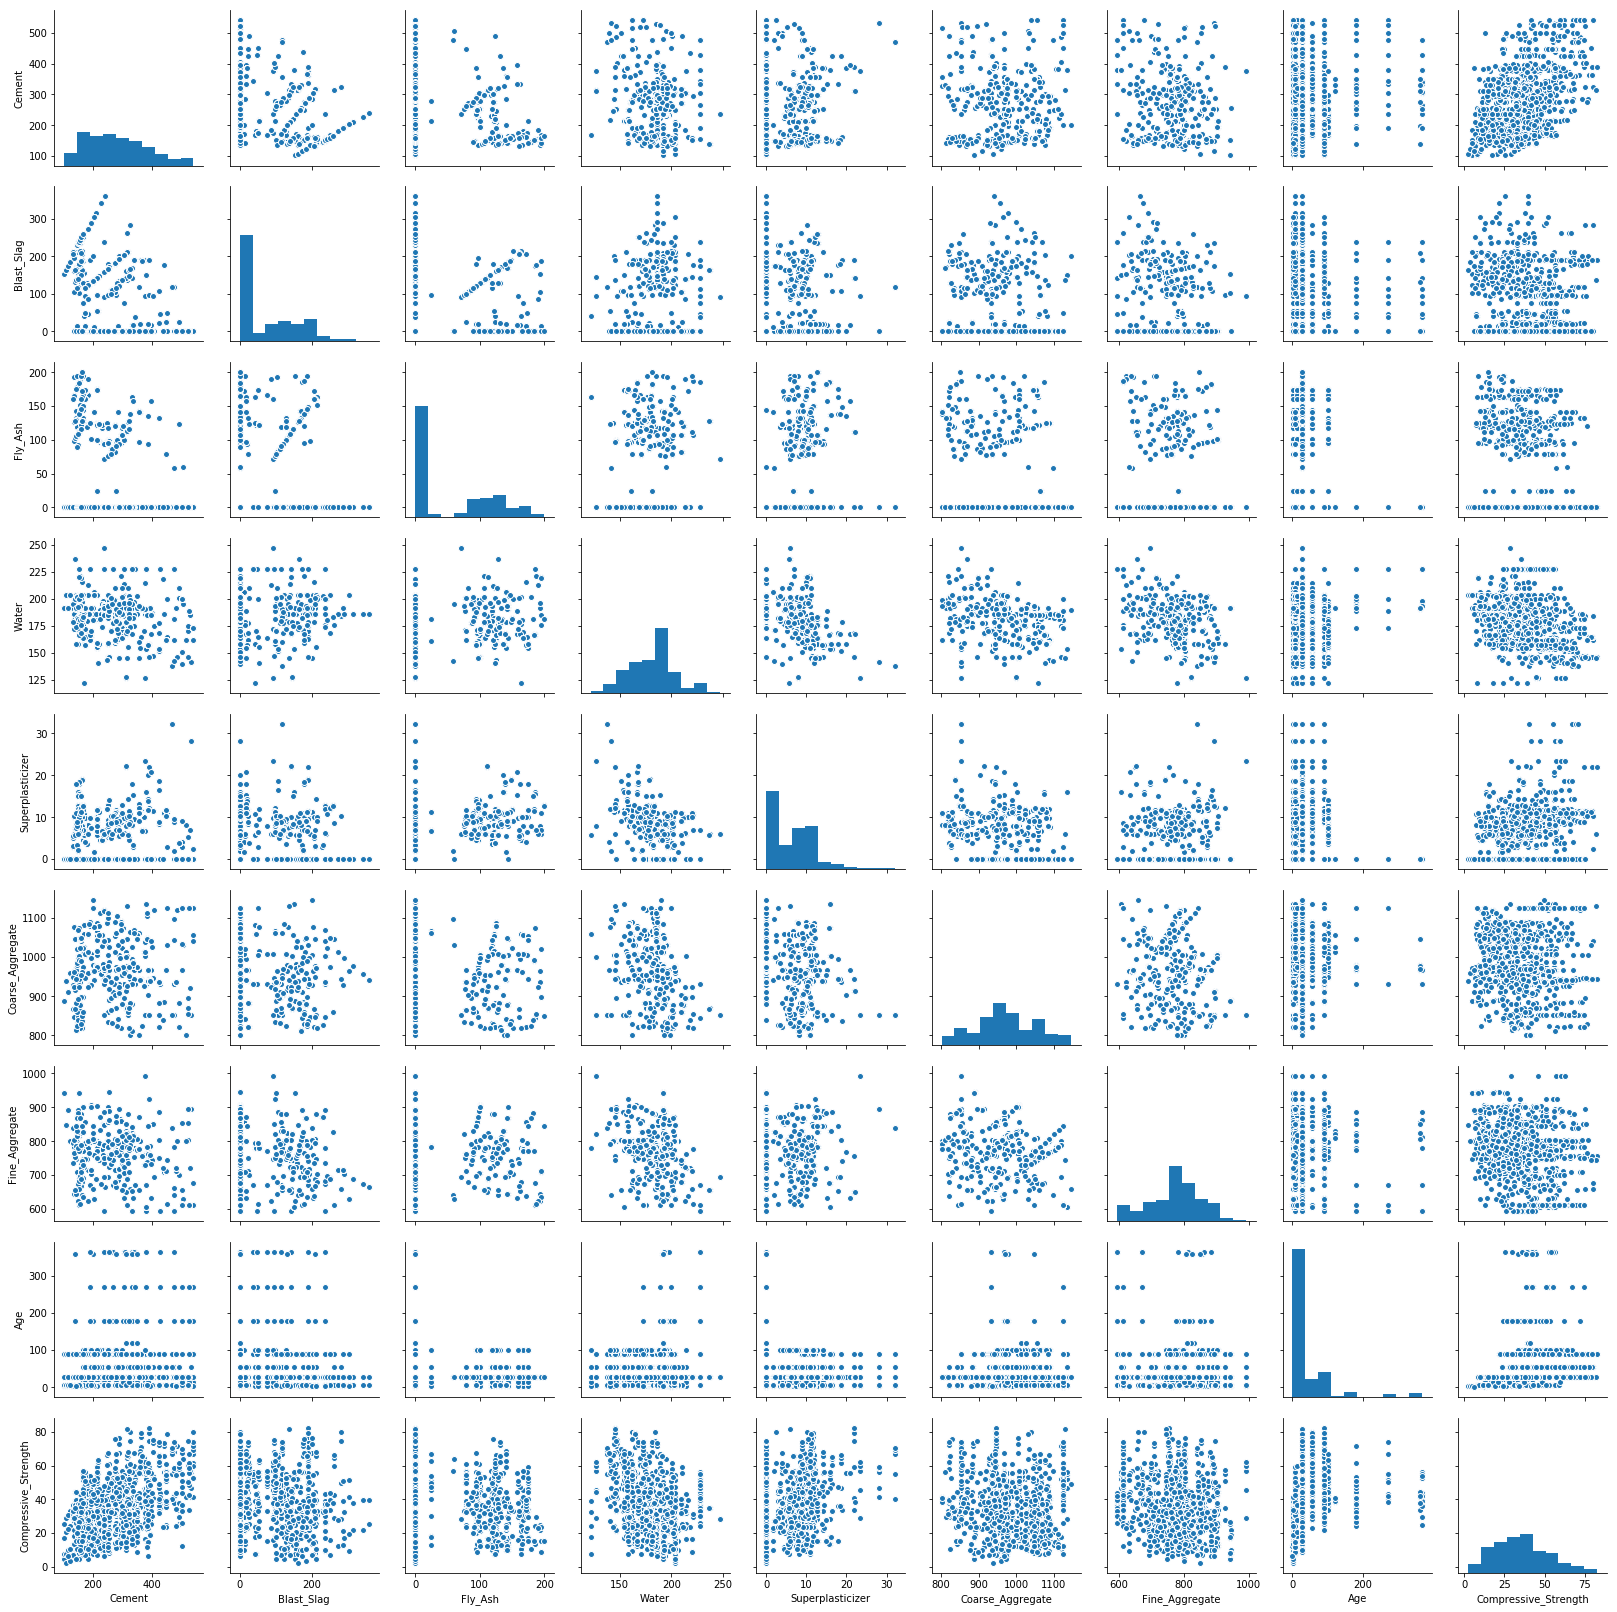

In [5]:
# Plot all values
sns.pairplot(concrete)
plt.show()

# Part 2: Simple Regression

Now I'm going to do some simple regression, using each model individually. For this, I'll divide up features into X and Y, then train/test split them.

In [6]:
# Split features and outccome
X = concrete.drop(['Compressive_Strength'], axis = 1)
Y = concrete.Compressive_Strength

# Split to train/test (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12)

### 2.1: Linear Regression

Here's a simple linear regression, including the R^2 score:

In [7]:
# Create a model instance
lr = LinearRegression()

# Train model on data
lr.fit(X_train, Y_train)

# Score on test data (R^2)
lr.score(X_test, Y_test)

0.5688221296382397

It's probably more instructive to see this in plot form....here's a function to plot and predict with a model:

In [8]:
def predictAndPlot(model, X_test, Y_test, plot_flag = True):
    
    '''Given a fit regression model and test data, predict and plot in comparison to actual'''
    
    # Take in the fit model
    Y_pred = model.predict(X_test)
    
    # If plot flag, then plot it
    if plot_flag:
        
        # Create a dataframe of predicted and actual
        plot_data = pd.DataFrame({'Actual' : Y_test,
                                  'Predicted' : Y_pred})
    
        # Plot using Seaborn
        sns.lmplot(data = plot_data, 
                   x = 'Actual',
                   y = 'Predicted',
                   fit_reg= False)
    
        # Also plot the 45 Line
        plt.plot([0, 80], [0, 80], color = 'red')    
        
        # Add text with score
        r_2 = model.score(X_test, Y_test)
        plt.text( x = 0, y = 80, s = "R^2 = {:0.2f}".format(r_2),
                 fontsize = 16)
        plt.show()
    
    return Y_pred

Now I'll try out the function

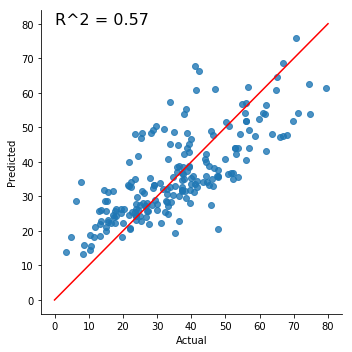

In [9]:
Y_pred_lr = predictAndPlot(lr, X_test, Y_test)

A word on this function: it seems to only work (the Latex part that is) every other time. Not certain why, but it's annoying

## 2.2: Random Forest Regression

I'll do the same exact thing, but use a random forest regressor:

In [10]:
# Create a model instance
rf = RandomForestRegressor()

# Train model on data
rf.fit(X_train, Y_train)

# Score on test data (R^2)
rf.score(X_test, Y_test)

0.889294170221569

Note that the score is MUCH higher, which isn't necessarily surprising. Now for the prediction plot:

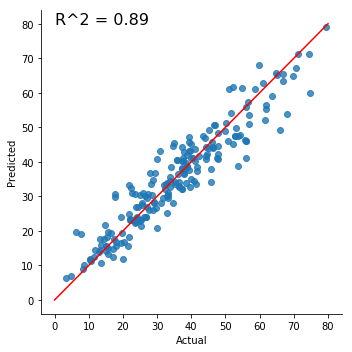

In [11]:
Y_pred_rf = predictAndPlot(rf, X_test, Y_test)

Much better looking; now for the final single model:

## 2.3 Gradient Boosted Regression

Same as before, but different model:

In [12]:
# Create a model instance
gb = GradientBoostingRegressor()

# Train model on data
gb.fit(X_train, Y_train)

# Score on test data (R^2)
gb.score(X_test, Y_test)

0.893425296242777

Best score yet, which is kind of what I was expecting. Final prediction plot:

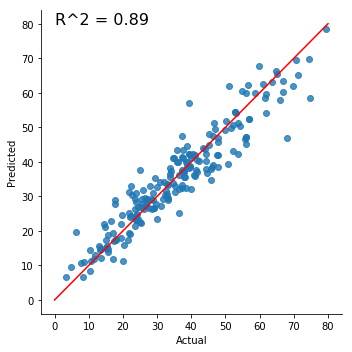

In [13]:
Y_pred_gb = predictAndPlot(gb, X_test, Y_test)

# Part 3: Cross Validation

Above, I did a random split for training/test. It's probably a good idea for me to instead compare models via their cross-validation scores. For that, I've got the following function:

In [14]:
# Function for one model
def doCV(model, X, Y): 
        
    # Create models
    cv_scores = cross_val_score(model, X, Y, cv = 5,
                                 scoring = 'neg_mean_squared_error')
      
    # Return R^2 average
    return np.mean(cv_scores), cv_scores

*Important note: other metrics for regression scoring are [here](http://scikit-learn.org/stable/modules/model_evaluation.html)*

This function will be used to get the mean CV score for each method; I'll do it in list comprehension form:

In [15]:
model_list = zip([lr, rf, gb], ['Linear Regression', 'Random Forest', 'Gradient Boosting'])

dummy_var = [print("{} Score: {:0.2f}".format(name, doCV(model, X, Y)[0])) for model, name in model_list]

Linear Regression Score: -128.11
Random Forest Score: -143.76
Gradient Boosting Score: -101.76


In [16]:
_, all_scores = doCV(rf, X, Y)
print(all_scores)

[-106.07052913  -88.41403788  -56.11564125  -40.4800554  -362.88761562]


This is weird; I think these indicate that some of the features are skewed and I should correct via a scaling or something...let's try preprocessing:!

In [17]:
# Preprocess the features by scaling
X_scaled = scale(X)

# Try the cross-validation again
model_list = zip([lr, rf, gb], ['Linear Regression', 'Random Forest', 'Gradient Boosting'])
dummy_var = [print("{} Score: {:0.2f}".format(name, doCV(model, X_scaled, Y)[0])) for model, name in model_list]

Linear Regression Score: -128.11
Random Forest Score: -125.69
Gradient Boosting Score: -101.44


Still weird! I'm going to push forward from here, because I want to show some other techniques.

# Part 4: Evaluating the Models

I want to be able to examine the features; here's how to do that for different models. First, I'll take a look at the coefficients of the linear model:

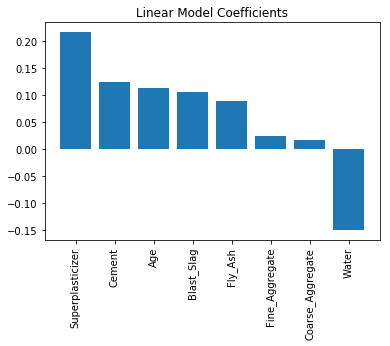

In [18]:
# Extract the coefficients
coefficients = lr.coef_
idx = np.flip(np.argsort(coefficients), 0)
labels =np.array(concrete.drop(['Compressive_Strength'], axis = 1).columns)
plt.figure()
plt.bar(list(range(len(coefficients))),coefficients[idx])
plt.xticks(list(range(len(coefficients))), labels[idx], rotation='vertical')
plt.title('Linear Model Coefficients')
plt.show()

That's the size of the coefficients; now let's look at P-values as well, using the alternate linear model maker from the stats module:

In [19]:
# Fit linear regression from stats models
X2 = sm.add_constant(X_train)
est = sm.OLS(Y_train, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     Compressive_Strength   R-squared:                       0.625
Model:                              OLS   Adj. R-squared:                  0.621
Method:                   Least Squares   F-statistic:                     169.8
Date:                  Fri, 03 Aug 2018   Prob (F-statistic):          7.71e-168
Time:                          15:10:30   Log-Likelihood:                -3094.0
No. Observations:                   824   AIC:                             6206.
Df Residuals:                       815   BIC:                             6249.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -

So based upon this, the constant and the coarse aggregate don't have significant P-values, but the other factors do. So all the large coefficients ARE significant!

Now I will take a look at feature importances for the gradient boosted models:

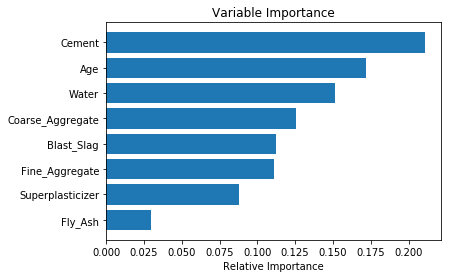

In [20]:
# Sort by feature importances
sorted_idx = np.argsort(gb.feature_importances_)

# Set bar positions and plot them as such
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gb.feature_importances_[sorted_idx], align='center')

# Use the index and the labels (from LM code) to label
importance_labels = [labels[i] for i in sorted_idx]
plt.yticks(pos, importance_labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In this case, it looks like the variable importances are a little different. The cement variable, which had a pretty high coefficient in the linear model, has the highest importance here.

That's all fine and good, but I'd like to get a better look; I'm going to try using Lime, which claims to help with this:

In [28]:
# Create the explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode = 'regression', #Point at the features and tell it we're doing regression
                                                   feature_names=list(X.columns), # Give names to the features
                                                   class_names=['Compressive_Strength'], # Name the response
#                                                    categorical_features=categorical_features, 
                                                   verbose = True) # Print out more text , 


In [32]:
# Explain a particular point that we predict with the moel
exp = explainer.explain_instance(X_test.iloc[2], rf.predict, num_features = 6)
exp.show_in_notebook(show_table = True)

Intercept 27.58883215927397
Prediction_local [67.30651084]
Right: 55.782400517999996


In [34]:
# Explain a different point that we predict with the moel
exp = explainer.explain_instance(X_test.iloc[1], rf.predict, num_features = 6)
exp.show_in_notebook(show_table = True)

Intercept 45.72490147549155
Prediction_local [14.30257286]
Right: 12.009224020400001


In the first case, all the different predictors point toward a high value, so the resulting value is high. More specifically:

- High Cement is the most important
- A midling Age is next, followed by low Water, high Superplasticizer, lower Fine_Aggregate, and middling Blast_Slag

In the second case, all predictors but the last one point toward a low value (and the last one does so weakly), so it ends up with a low value. More specifically:

- Low Age is the most important
- Zero Blast_Slag is next, followed by middling Water and Cement, then an offset (wrong direction) from Superplasticizer and finally, high Fine_aggregate

Ultimately, I don't know exactly how well this helps the overall model, but it certainly helps with a given prediction in knowing why we're getting what we're getting. If I had to explain 1 individual prediction, this would be super useful. 